***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- Applying bottom-up approach. (Fine-to-Coarse)
- Changing the Secondary Capsule Dimension:
    - 16D>12D>8D (Fine>Medium>Coarse)
    - Just use Hinge Loss (MarginLoss) for each level.
    

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet_MOD\Training_and_Analysis\4_CIFAR-100
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "7" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  7
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


## log directory

In [4]:
directory = sysenv.log_dir('MOD_1/4_CIFAR_100/HD_CapsNet/BU_WO_C_loss')

FOLDER CREATED =  ../../logs/MOD_1/4_CIFAR_100/HD_CapsNet/BU_WO_C_loss


# Import Dataset : CIFAR-100

In [5]:
dataset = datasets.CIFAR100(version = 'ALL') # importing CIFAR10 Dataset
# dataset = datasets.CIFAR100(version = 'reduce') # importing CIFAR10 Dataset


CIFAR-100 dataset: Training have 50,000 samples and testing have 10,000 samples


# Parameters

In [6]:
from src.models import *

In [7]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

## Learning Rate Decay Scheduler

In [8]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Bottom up Approach

## Loss Function

In [9]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_m = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "medium": number_of_classes_m,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [10]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")
    return total_marginloss

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F):
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*margin_loss(y_true_m, y_pred_m)
    ML_f = LW_F*margin_loss(y_true_f, y_pred_f)
    batch_loss = ML_c + ML_m+ ML_f
    return tf.reduce_mean(batch_loss)

## Model Architecture

In [11]:
def get_compiled_model():
    input_shape = dataset['x_train'].shape[1:]

    input_shape_yc = dataset['y_train_coarse'].shape[1:]
    input_shape_ym = dataset['y_train_medium'].shape[1:]
    input_shape_yf = dataset['y_train_fine'].shape[1:]

    no_coarse_class = number_of_classes_c
    no_medium_class = number_of_classes_m
    no_fine_class = number_of_classes_f

    PCap_n_dims = 8

    SCap_f_dims = 16
    SCap_m_dims = 12
    SCap_c_dims = 8


    # Input image
    x_input = keras.layers.Input(shape=input_shape, name="Input_Image")

    # Input True Labels
    y_c = keras.layers.Input(shape=input_shape_yc, name='input_yc')
    y_m = keras.layers.Input(shape=input_shape_ym, name='input_ym')
    y_f = keras.layers.Input(shape=input_shape_yf, name='input_yf')

    #--- block 1 ---
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x_input)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    #--- block 2 ---
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    #--- block 3 ---
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    #--- block 4 ---
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)


    # Layer 3: Reshape to 8D primary capsules 
    # input [batch_size, 6, 6, 512], output [batch_size, 2304, 8]
    reshapec = keras.layers.Reshape((256, PCap_n_dims), name="reshape_layer")(x)
    p_caps = keras.layers.Lambda(squash, name='p_caps')(reshapec)

    ## Layer Secondary Capsule: For fine level
    s_caps_f = SecondaryCapsule(n_caps=no_fine_class, n_dims=SCap_f_dims, 
                        name="s_caps_fine")(p_caps)

    ## Layer Secondary Capsule: For medium level
    s_caps_m = SecondaryCapsule(n_caps=no_medium_class, n_dims=SCap_m_dims, 
                        name="s_caps_medium")(s_caps_f)

    ## Layer Secondary Capsule: For coarse level
    s_caps_c = SecondaryCapsule(n_caps=no_coarse_class, n_dims=SCap_c_dims, 
                        name="s_caps_coarse")(s_caps_m)

    pred_c = LengthLayer(name='prediction_coarse')(s_caps_c)

    pred_m = LengthLayer(name='prediction_medium')(s_caps_m)

    pred_f = LengthLayer(name='prediction_fine')(s_caps_f)

    model = keras.Model(inputs= [x_input, y_c, y_m, y_f],
                        outputs= [pred_c, pred_m, pred_f],
                        name='HD-CapsNet')

    model.add_loss(CustomLoss(y_c, y_m, y_f, pred_c, pred_m, pred_f, 
                              lossweight['coarse_lw'], lossweight['medium_lw'], lossweight['fine_lw']))

    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'
                          }
    )
    return model

In [12]:
model = get_compiled_model()

In [13]:
model.summary()
# keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 32, 32, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 32, 32, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.math.subtract_3 (TFOpLambda  (None, 20)          0           ['prediction_medium[0][0]']      
 )                                                                                                
                                                                                                  
 tf.math.subtract_4 (TFOpLambda  (None, 20)          0           ['prediction_medium[0][0]']      
 )                                                                                                
                                                                                                  
 tf.math.maximum (TFOpLambda)   (None, 8)            0           ['tf.math.subtract[0][0]']       
                                                                                                  
 tf.math.subtract_2 (TFOpLambda  (None, 8)           0           ['input_yc[0][0]']               
 )        

 da)                                                                                              
                                                                                                  
 tf.math.add_2 (TFOpLambda)     (None, 100)          0           ['tf.math.multiply_8[0][0]',     
                                                                  'tf.math.multiply_10[0][0]']    
                                                                                                  
 tf.math.multiply_3 (TFOpLambda  (None,)             0           ['tf.math.reduce_sum[0][0]']     
 )                                                                                                
                                                                                                  
 tf.math.multiply_7 (TFOpLambda  (None,)             0           ['tf.math.reduce_sum_1[0][0]']   
 )                                                                                                
          

## Data Augmentation

In [14]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [15]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(
    directory+'/weights-{epoch:02d}.h5', 
    monitor='val_prediction_fine_accuracy',
    save_best_only=True, save_weights_only=True, verbose=1)
change_lw = LossWeightsModifier(lossweight = lossweight,
                               initial_lw = initial_lw,
                               directory = directory)
lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [16]:
history = model.fit(training_generator,
                    steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                    epochs = train_params["n_epochs"],
                    validation_data = ([dataset['x_test'],
                                        dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                       [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]),
                    callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                    
                    verbose=1)
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.save_weights(model_save_dir)
    print('Trained model saved to = ', model_save_dir)
except:
    print('Model Wight is not saved')

Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 0.5142 - prediction_coarse_accuracy: 0.3729 - prediction_medium_accuracy: 0.2121 - prediction_fine_accuracy: 0.0979
  • Coarse Accuracy = 37.29% | Val_Accuracy = 55.42% | LossWeight = 0.41 
  • Medium Accuracy = 21.21% | Val_Accuracy = 32.81% | LossWeight = 0.46 
  • Fine   Accuracy = 9.79% | Val_Accuracy = 14.43% | LossWeight = 0.14 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.14430, saving model to ../../logs/MOD_1/4_CIFAR_100/HD_CapsNet/BU_WO_C_loss\weights-01.h5
781/781 [==============================] - 156s 190ms/step - loss: 0.5142 - prediction_coarse_accuracy: 0.3729 - prediction_medium_accuracy: 0.2121 - prediction_fine_accuracy: 0.0979 - val_loss: 0.3950 - val_prediction_coarse_accuracy: 0.5542 - val_prediction_medium_accuracy: 0.3281 - val_prediction_fine_accuracy: 0.1443 - lr: 0.0010
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 0.3640 - prediction_coarse_accur

781/781 [==============================] - ETA: 0s - loss: 0.1904 - prediction_coarse_accuracy: 0.8471 - prediction_medium_accuracy: 0.7527 - prediction_fine_accuracy: 0.5287
  • Coarse Accuracy = 84.71% | Val_Accuracy = 80.40% | LossWeight = 0.32 
  • Medium Accuracy = 75.27% | Val_Accuracy = 68.84% | LossWeight = 0.46 
  • Fine   Accuracy = 52.87% | Val_Accuracy = 49.69% | LossWeight = 0.23 

Epoch 9: val_prediction_fine_accuracy improved from 0.49590 to 0.49690, saving model to ../../logs/MOD_1/4_CIFAR_100/HD_CapsNet/BU_WO_C_loss\weights-09.h5
781/781 [==============================] - 150s 193ms/step - loss: 0.1904 - prediction_coarse_accuracy: 0.8471 - prediction_medium_accuracy: 0.7527 - prediction_fine_accuracy: 0.5287 - val_loss: 0.1824 - val_prediction_coarse_accuracy: 0.8040 - val_prediction_medium_accuracy: 0.6884 - val_prediction_fine_accuracy: 0.4969 - lr: 0.0010
Epoch 10/100
781/781 [==============================] - ETA: 0s - loss: 0.1804 - prediction_coarse_accuracy: 0.

Epoch 18/100
781/781 [==============================] - ETA: 0s - loss: 0.1314 - prediction_coarse_accuracy: 0.9242 - prediction_medium_accuracy: 0.8810 - prediction_fine_accuracy: 0.6787
  • Coarse Accuracy = 92.42% | Val_Accuracy = 84.11% | LossWeight = 0.29 
  • Medium Accuracy = 88.10% | Val_Accuracy = 74.86% | LossWeight = 0.42 
  • Fine   Accuracy = 67.87% | Val_Accuracy = 58.76% | LossWeight = 0.29 

Epoch 18: val_prediction_fine_accuracy improved from 0.57880 to 0.58760, saving model to ../../logs/MOD_1/4_CIFAR_100/HD_CapsNet/BU_WO_C_loss\weights-18.h5
781/781 [==============================] - 152s 195ms/step - loss: 0.1314 - prediction_coarse_accuracy: 0.9242 - prediction_medium_accuracy: 0.8810 - prediction_fine_accuracy: 0.6787 - val_loss: 0.1545 - val_prediction_coarse_accuracy: 0.8411 - val_prediction_medium_accuracy: 0.7486 - val_prediction_fine_accuracy: 0.5876 - lr: 6.6342e-04
Epoch 19/100
781/781 [==============================] - ETA: 0s - loss: 0.1278 - prediction_c

Epoch 27/100
781/781 [==============================] - ETA: 0s - loss: 0.1124 - prediction_coarse_accuracy: 0.9418 - prediction_medium_accuracy: 0.9185 - prediction_fine_accuracy: 0.7409
  • Coarse Accuracy = 94.18% | Val_Accuracy = 84.41% | LossWeight = 0.30 
  • Medium Accuracy = 91.85% | Val_Accuracy = 75.85% | LossWeight = 0.38 
  • Fine   Accuracy = 74.09% | Val_Accuracy = 61.06% | LossWeight = 0.31 

Epoch 27: val_prediction_fine_accuracy improved from 0.60680 to 0.61060, saving model to ../../logs/MOD_1/4_CIFAR_100/HD_CapsNet/BU_WO_C_loss\weights-27.h5
781/781 [==============================] - 152s 195ms/step - loss: 0.1124 - prediction_coarse_accuracy: 0.9418 - prediction_medium_accuracy: 0.9185 - prediction_fine_accuracy: 0.7409 - val_loss: 0.1500 - val_prediction_coarse_accuracy: 0.8441 - val_prediction_medium_accuracy: 0.7585 - val_prediction_fine_accuracy: 0.6106 - lr: 4.1812e-04
Epoch 28/100
781/781 [==============================] - ETA: 0s - loss: 0.1096 - prediction_c

781/781 [==============================] - ETA: 0s - loss: 0.1021 - prediction_coarse_accuracy: 0.9518 - prediction_medium_accuracy: 0.9361 - prediction_fine_accuracy: 0.7806
  • Coarse Accuracy = 95.18% | Val_Accuracy = 85.47% | LossWeight = 0.31 
  • Medium Accuracy = 93.61% | Val_Accuracy = 76.73% | LossWeight = 0.37 
  • Fine   Accuracy = 78.06% | Val_Accuracy = 62.46% | LossWeight = 0.33 

Epoch 36: val_prediction_fine_accuracy did not improve from 0.62630
781/781 [==============================] - 153s 195ms/step - loss: 0.1021 - prediction_coarse_accuracy: 0.9518 - prediction_medium_accuracy: 0.9361 - prediction_fine_accuracy: 0.7806 - val_loss: 0.1474 - val_prediction_coarse_accuracy: 0.8547 - val_prediction_medium_accuracy: 0.7673 - val_prediction_fine_accuracy: 0.6246 - lr: 2.6352e-04
Epoch 37/100
781/781 [==============================] - ETA: 0s - loss: 0.1021 - prediction_coarse_accuracy: 0.9516 - prediction_medium_accuracy: 0.9369 - prediction_fine_accuracy: 0.7839
  • Co

781/781 [==============================] - ETA: 0s - loss: 0.0997 - prediction_coarse_accuracy: 0.9538 - prediction_medium_accuracy: 0.9408 - prediction_fine_accuracy: 0.8036
  • Coarse Accuracy = 95.38% | Val_Accuracy = 85.72% | LossWeight = 0.32 
  • Medium Accuracy = 94.08% | Val_Accuracy = 77.42% | LossWeight = 0.37 
  • Fine   Accuracy = 80.36% | Val_Accuracy = 63.54% | LossWeight = 0.32 

Epoch 45: val_prediction_fine_accuracy did not improve from 0.63950
781/781 [==============================] - 152s 195ms/step - loss: 0.0997 - prediction_coarse_accuracy: 0.9538 - prediction_medium_accuracy: 0.9408 - prediction_fine_accuracy: 0.8036 - val_loss: 0.1453 - val_prediction_coarse_accuracy: 0.8572 - val_prediction_medium_accuracy: 0.7742 - val_prediction_fine_accuracy: 0.6354 - lr: 1.6608e-04
Epoch 46/100
781/781 [==============================] - ETA: 0s - loss: 0.0991 - prediction_coarse_accuracy: 0.9553 - prediction_medium_accuracy: 0.9417 - prediction_fine_accuracy: 0.8082
  • Co

781/781 [==============================] - 152s 194ms/step - loss: 0.0961 - prediction_coarse_accuracy: 0.9562 - prediction_medium_accuracy: 0.9439 - prediction_fine_accuracy: 0.8206 - val_loss: 0.1440 - val_prediction_coarse_accuracy: 0.8592 - val_prediction_medium_accuracy: 0.7779 - val_prediction_fine_accuracy: 0.6406 - lr: 1.0467e-04
Epoch 55/100
781/781 [==============================] - ETA: 0s - loss: 0.0974 - prediction_coarse_accuracy: 0.9573 - prediction_medium_accuracy: 0.9455 - prediction_fine_accuracy: 0.8189
  • Coarse Accuracy = 95.73% | Val_Accuracy = 86.10% | LossWeight = 0.32 
  • Medium Accuracy = 94.55% | Val_Accuracy = 77.96% | LossWeight = 0.37 
  • Fine   Accuracy = 81.89% | Val_Accuracy = 64.34% | LossWeight = 0.32 

Epoch 55: val_prediction_fine_accuracy improved from 0.64060 to 0.64340, saving model to ../../logs/MOD_1/4_CIFAR_100/HD_CapsNet/BU_WO_C_loss\weights-55.h5
781/781 [==============================] - 152s 195ms/step - loss: 0.0974 - prediction_coarse

Epoch 64/100
781/781 [==============================] - ETA: 0s - loss: 0.0952 - prediction_coarse_accuracy: 0.9581 - prediction_medium_accuracy: 0.9459 - prediction_fine_accuracy: 0.8317
  • Coarse Accuracy = 95.81% | Val_Accuracy = 86.04% | LossWeight = 0.32 
  • Medium Accuracy = 94.59% | Val_Accuracy = 78.04% | LossWeight = 0.37 
  • Fine   Accuracy = 83.17% | Val_Accuracy = 64.34% | LossWeight = 0.30 

Epoch 64: val_prediction_fine_accuracy did not improve from 0.64500
781/781 [==============================] - 152s 195ms/step - loss: 0.0952 - prediction_coarse_accuracy: 0.9581 - prediction_medium_accuracy: 0.9459 - prediction_fine_accuracy: 0.8317 - val_loss: 0.1445 - val_prediction_coarse_accuracy: 0.8604 - val_prediction_medium_accuracy: 0.7804 - val_prediction_fine_accuracy: 0.6434 - lr: 6.2672e-05
Epoch 65/100
781/781 [==============================] - ETA: 0s - loss: 0.0954 - prediction_coarse_accuracy: 0.9572 - prediction_medium_accuracy: 0.9455 - prediction_fine_accuracy: 

781/781 [==============================] - 152s 195ms/step - loss: 0.0964 - prediction_coarse_accuracy: 0.9566 - prediction_medium_accuracy: 0.9464 - prediction_fine_accuracy: 0.8344 - val_loss: 0.1449 - val_prediction_coarse_accuracy: 0.8605 - val_prediction_medium_accuracy: 0.7809 - val_prediction_fine_accuracy: 0.6434 - lr: 3.9499e-05
Epoch 74/100
781/781 [==============================] - ETA: 0s - loss: 0.0963 - prediction_coarse_accuracy: 0.9582 - prediction_medium_accuracy: 0.9454 - prediction_fine_accuracy: 0.8346
  • Coarse Accuracy = 95.82% | Val_Accuracy = 86.19% | LossWeight = 0.32 
  • Medium Accuracy = 94.54% | Val_Accuracy = 78.37% | LossWeight = 0.38 
  • Fine   Accuracy = 83.46% | Val_Accuracy = 64.40% | LossWeight = 0.30 

Epoch 74: val_prediction_fine_accuracy did not improve from 0.64670
781/781 [==============================] - 152s 195ms/step - loss: 0.0963 - prediction_coarse_accuracy: 0.9582 - prediction_medium_accuracy: 0.9454 - prediction_fine_accuracy: 0.834

781/781 [==============================] - ETA: 0s - loss: 0.0947 - prediction_coarse_accuracy: 0.9586 - prediction_medium_accuracy: 0.9473 - prediction_fine_accuracy: 0.8394
  • Coarse Accuracy = 95.86% | Val_Accuracy = 86.19% | LossWeight = 0.33 
  • Medium Accuracy = 94.73% | Val_Accuracy = 78.34% | LossWeight = 0.38 
  • Fine   Accuracy = 83.94% | Val_Accuracy = 64.71% | LossWeight = 0.30 

Epoch 83: val_prediction_fine_accuracy improved from 0.64670 to 0.64710, saving model to ../../logs/MOD_1/4_CIFAR_100/HD_CapsNet/BU_WO_C_loss\weights-83.h5
781/781 [==============================] - 153s 195ms/step - loss: 0.0947 - prediction_coarse_accuracy: 0.9586 - prediction_medium_accuracy: 0.9473 - prediction_fine_accuracy: 0.8394 - val_loss: 0.1444 - val_prediction_coarse_accuracy: 0.8619 - val_prediction_medium_accuracy: 0.7834 - val_prediction_fine_accuracy: 0.6471 - lr: 2.3650e-05
Epoch 84/100
781/781 [==============================] - ETA: 0s - loss: 0.0952 - prediction_coarse_accurac

781/781 [==============================] - 152s 195ms/step - loss: 0.0941 - prediction_coarse_accuracy: 0.9585 - prediction_medium_accuracy: 0.9472 - prediction_fine_accuracy: 0.8435 - val_loss: 0.1454 - val_prediction_coarse_accuracy: 0.8615 - val_prediction_medium_accuracy: 0.7838 - val_prediction_fine_accuracy: 0.6478 - lr: 1.4905e-05
Epoch 93/100
781/781 [==============================] - ETA: 0s - loss: 0.0935 - prediction_coarse_accuracy: 0.9581 - prediction_medium_accuracy: 0.9470 - prediction_fine_accuracy: 0.8427
  • Coarse Accuracy = 95.81% | Val_Accuracy = 86.10% | LossWeight = 0.33 
  • Medium Accuracy = 94.70% | Val_Accuracy = 78.44% | LossWeight = 0.38 
  • Fine   Accuracy = 84.27% | Val_Accuracy = 64.69% | LossWeight = 0.29 

Epoch 93: val_prediction_fine_accuracy did not improve from 0.64790
781/781 [==============================] - 152s 195ms/step - loss: 0.0935 - prediction_coarse_accuracy: 0.9581 - prediction_medium_accuracy: 0.9470 - prediction_fine_accuracy: 0.842

In [17]:
history_dict = history.history

(0.0, 1.0)

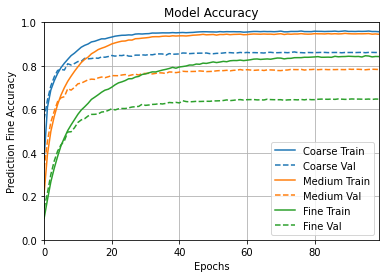

In [18]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
plt.title("Model Accuracy")
plt.ylim([0,1])

(0.0, 1.0)

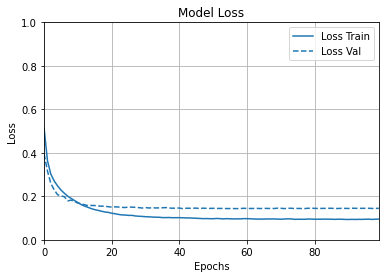

In [19]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"loss": history}, metric = "loss")
plt.title("Model Loss")
plt.ylim([0,1])

## Model Analysis

In [20]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : MarginLoss(),
                          'prediction_medium' : MarginLoss(),
                          'prediction_coarse' : MarginLoss()},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

313/313 [==============================] - 13s 37ms/step - loss: 0.1859 - prediction_coarse_loss: 0.1229 - prediction_medium_loss: 0.1762 - prediction_fine_loss: 0.2728 - prediction_coarse_accuracy: 0.8618 - prediction_medium_accuracy: 0.7831 - prediction_fine_accuracy: 0.6469
1. loss ==> 0.18594993650913239
2. prediction_coarse_loss ==> 0.12289910018444061
3. prediction_medium_loss ==> 0.17621901631355286
4. prediction_fine_loss ==> 0.27284571528434753
5. prediction_coarse_accuracy ==> 0.8618000149726868
6. prediction_medium_accuracy ==> 0.7831000089645386
7. prediction_fine_accuracy ==> 0.6468999981880188
313/313 [==============================] - 10s 31ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

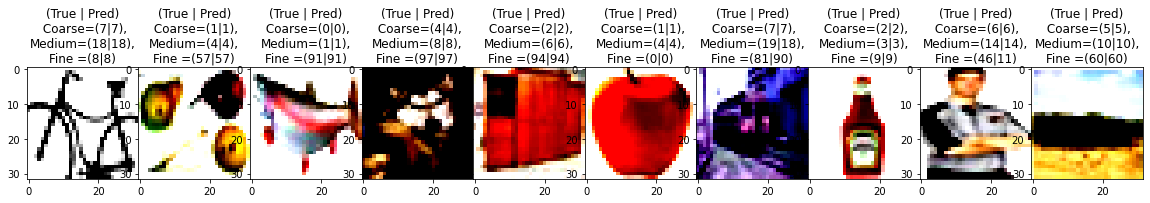

In [21]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 722   12   27   27  176   15   13    8]
 [   8 1377   34   28   32   17    3    1]
 [  13   33 1359   15   30   14    9   27]
 [  23   44   38  785   93    1    3   13]
 [  98   31   61   86 2178   13   13   20]
 [   8   31   21    6   28  884    0   22]
 [  10   15   17   11   31    1  411    4]
 [   3    4   33    9   27   21    1  902]]

  • MEDIUM LEVEL 
[[321  29   1   1   4   8   4   1  10   3   3  14  22  12   5  36  22   0
    1   3]
 [ 34 358   4   7   5   8   2   7   2   3   5   2   3  14   9  23  10   0
    3   1]
 [  1   4 441   3  18   6   1  10   1   1   1   0   0   2   1   4   1   2
    1   2]
 [  1   2   4 409  13  30   3   3   2   3   0   1   1   5   6   4   2   1
    3   7]
 [  3   0  20   9 421   7   3   8   3   0   1   0   2   9   2   5   3   4
    0   0]
 [  1   7   1  27   9 389  23   1   1   3   3   0   1   6   6   4   1   1
    6  10]
 [  1   2   2  11   3  20 434   0   2   4   4   0   2   2   1   0   1   1
    6   4]


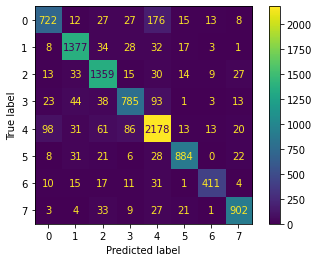

              precision    recall  f1-score   support

           0    0.81582   0.72200   0.76605      1000
           1    0.89011   0.91800   0.90384      1500
           2    0.85472   0.90600   0.87961      1500
           3    0.81179   0.78500   0.79817      1000
           4    0.83931   0.87120   0.85496      2500
           5    0.91511   0.88400   0.89929      1000
           6    0.90728   0.82200   0.86254       500
           7    0.90471   0.90200   0.90336      1000

    accuracy                        0.86180     10000
   macro avg    0.86736   0.85128   0.85848     10000
weighted avg    0.86166   0.86180   0.86107     10000


  • MEDIUM LEVEL 


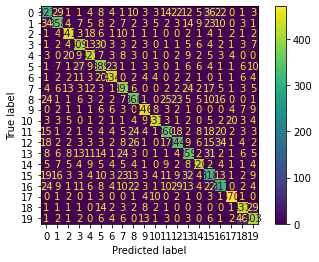

              precision    recall  f1-score   support

           0    0.66322   0.64200   0.65244       500
           1    0.77996   0.71600   0.74661       500
           2    0.85135   0.88200   0.86640       500
           3    0.79417   0.81800   0.80591       500
           4    0.79584   0.84200   0.81827       500
           5    0.70985   0.77800   0.74237       500
           6    0.86111   0.86800   0.86454       500
           7    0.75775   0.78200   0.76969       500
           8    0.74494   0.73600   0.74044       500
           9    0.87451   0.89200   0.88317       500
          10    0.90546   0.86200   0.88320       500
          11    0.77922   0.72000   0.74844       500
          12    0.73662   0.68800   0.71148       500
          13    0.70530   0.71800   0.71160       500
          14    0.86777   0.84000   0.85366       500
          15    0.60803   0.63600   0.62170       500
          16    0.69670   0.63400   0.66387       500
          17    0.91618   0

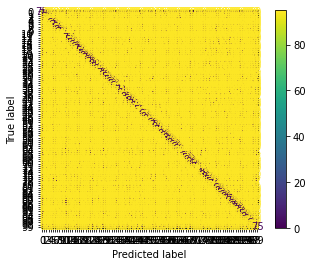

              precision    recall  f1-score   support

           0    0.85227   0.75000   0.79787       100
           1    0.72222   0.78000   0.75000       100
           2    0.60976   0.50000   0.54945       100
           3    0.52113   0.37000   0.43275       100
           4    0.42268   0.41000   0.41624       100
           5    0.64762   0.68000   0.66341       100
           6    0.76042   0.73000   0.74490       100
           7    0.62264   0.66000   0.64078       100
           8    0.80392   0.82000   0.81188       100
           9    0.80208   0.77000   0.78571       100
          10    0.49474   0.47000   0.48205       100
          11    0.47475   0.47000   0.47236       100
          12    0.70000   0.77000   0.73333       100
          13    0.63441   0.59000   0.61140       100
          14    0.50000   0.55000   0.52381       100
          15    0.58182   0.64000   0.60952       100
          16    0.67347   0.66000   0.66667       100
          17    0.87640   0

In [22]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [23]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                       pred_label,
                                       dataset['tree'])
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.7614099999999999 
Hierarchical Recall = 0.7798333333333333 
Hierarchical F1-Score = 0.7685821428571429 
Consistency =  0.8983 
Exact Match =  0.6239
